In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('bidmc_04_Numerics.csv')

# Fill NaN values with the mean of each column
data.fillna(data.mean(), inplace=True)

# Select the physiological parameters
physiological_params = [' HR', ' PULSE', ' RESP', ' SpO2', 'SYS', 'DIA']
X = data[physiological_params].values

# Normalize the data
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / (X_std + 1e-8)  # Add a small value to avoid division by zero

# Split the data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Define the generator model
def build_generator(latent_dim, num_features):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_dim=latent_dim),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_features, activation='tanh')
    ])
    return model

# Define the discriminator model
def build_discriminator(num_features):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=num_features),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Define the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = keras.Sequential([generator, discriminator])
    return model

# Define the generator input
latent_dim = 32
num_features = 6  # Number of physiological parameters

# Build and compile the discriminator
discriminator = build_discriminator(num_features)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

# Build the generator
generator = build_generator(latent_dim, num_features)

# Build and compile the GAN
gan_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
gan = build_gan(generator, discriminator)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

# Define a function to generate fake samples
def generate_fake_samples(generator, latent_dim, num_samples):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    fake_samples = generator.predict(noise)
    return fake_samples

# Train the GAN
epochs = 10000
batch_size = 128
for epoch in range(epochs):
    # Select a random batch of real samples
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_samples = X_train[idx]

    # Generate a batch of fake samples
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = generator.predict(noise)

    # Train the discriminator
    discriminator_loss_real = discriminator.train_on_batch(real_samples, np.ones((batch_size, 1)))
    discriminator_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((batch_size, 1)))
    discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

    # Train the generator (via the GAN model)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generator_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")

# Evaluate the model on the test set
test_loss = gan.evaluate(np.random.normal(0, 1, (X_test.shape[0], latent_dim)), np.ones((X_test.shape[0], 1)))
print("Test Loss:", test_loss)


Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 2ms/step
Epoch: 5100, Discriminator Loss: 0.5000006556510925, Generator Loss: 0.9844328165054321
4/4 [==============================] - 0s 3ms/step
Epoch: 5200, Discriminator Loss: 0.5244710445404053, Generator Loss: 0.9938281774520874
4/4 [==============================] - 0s 3ms/step
Epoch: 5300, Discriminator Loss: 0.5114581733942032, Generator Loss: 1.0265116691589355
4/4 [==============================] - 0s 3ms/step
Epoch: 5400, Discriminator Loss: 0.4811202436685562, Generator Loss: 1.0166196823120117
4/4 [==============================] - 0s 3ms/step
Epoch: 5500, Discriminator Loss: 0.5258536338806152, Generator Loss: 0.9826193451881409
4/4 [==============================] - 0s 3ms/step
Epoch: 5600, Discriminator Loss: 0.4736810475587845, Generator Loss: 1.005241870880127
4/4 [==============================] - 0s 3ms/step
Epoch: 5700, Discriminator Loss: 0.5423652231693268, Generator Lo

32/32 [==============================] - 0s 1ms/step


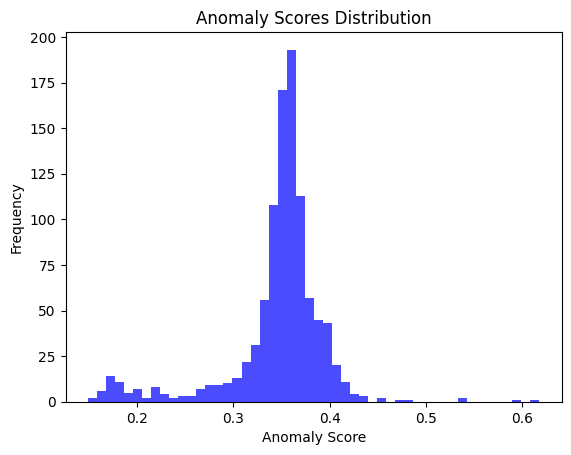

In [ ]:
import matplotlib.pyplot as plt

num_fake_samples = 1000
noise = np.random.normal(0, 1, (num_fake_samples, latent_dim))
fake_samples = generator.predict(noise)

# Use the discriminator to classify the fake samples
anomaly_scores = discriminator.predict(fake_samples)

# Visualize the anomaly scores
plt.hist(anomaly_scores, bins=50, color='blue', alpha=0.7)
plt.title('Anomaly Scores Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

32/32 [==============================] - 0s 1ms/step


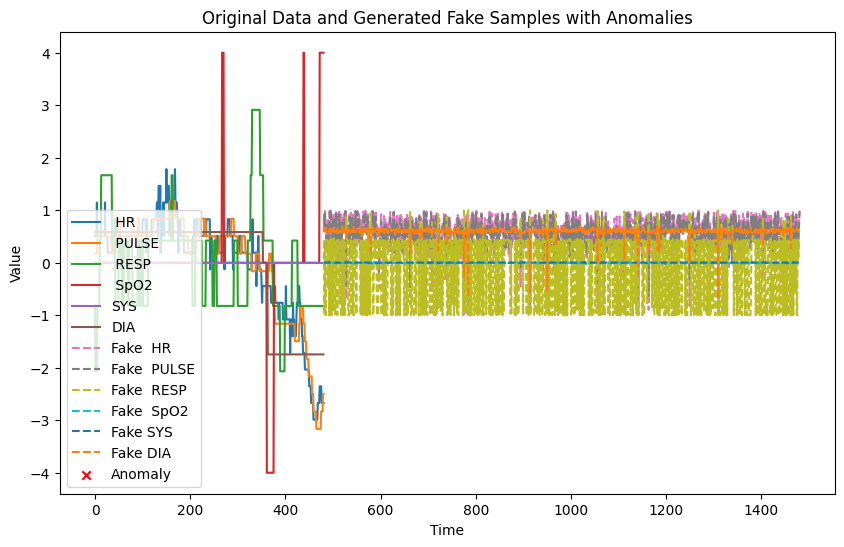

In [ ]:
# Generate fake samples using the generator
num_fake_samples = 1000
noise = np.random.normal(0, 1, (num_fake_samples, latent_dim))
fake_samples = generator.predict(noise)

# Detect anomalies using the discriminator
anomaly_scores = discriminator.predict(fake_samples)
threshold = 0.5  # Adjust the threshold as needed

# Plot the original data
plt.figure(figsize=(10, 6))
for i in range(X.shape[1]):
    plt.plot(range(X.shape[0]), X[:, i], label=physiological_params[i])

# Plot the generated fake samples
for i in range(fake_samples.shape[1]):
    plt.plot(range(X.shape[0], X.shape[0] + num_fake_samples), fake_samples[:, i], linestyle='--', label=f'Fake {physiological_params[i]}')

# Identify anomalous samples
anomalous_indices = np.where(anomaly_scores > threshold)[0]
anomalous_times = list(range(X.shape[0], X.shape[0] + num_fake_samples))
anomalous_values = fake_samples[anomalous_indices]

# Plot the anomalous samples
plt.scatter(anomalous_times[:len(anomalous_values)], anomalous_values[:, 0], color='red', marker='x', label='Anomaly')

plt.title('Original Data and Generated Fake Samples with Anomalies')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


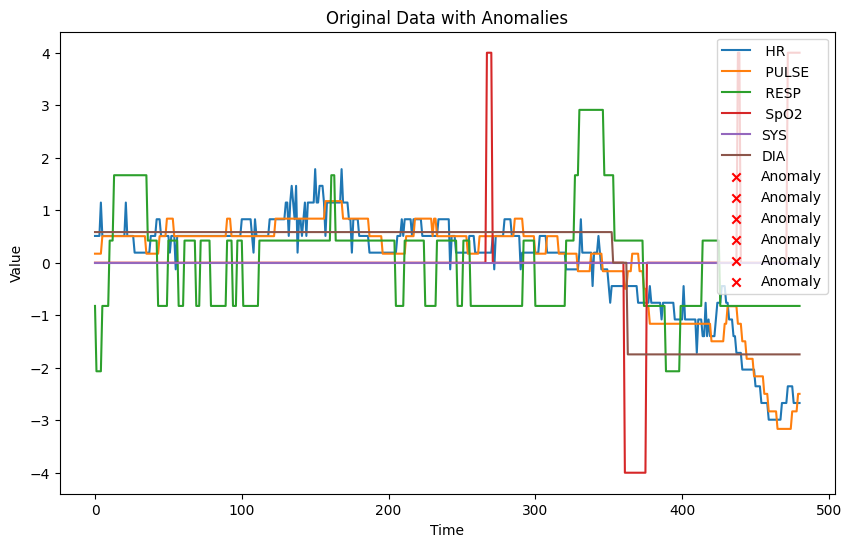

In [ ]:
# Plot the original data for HR, PULSE, RESP, SpO2, SYS, DIA
plt.figure(figsize=(10, 6))
params_to_plot = [' HR', ' PULSE', ' RESP', ' SpO2', 'SYS', 'DIA']
for param in params_to_plot:
    plt.plot(range(X.shape[0]), X[:, physiological_params.index(param)], label=param)

# Identify anomalous samples
anomalous_indices = np.where(anomaly_scores > threshold)[0]
anomalous_times = list(range(X.shape[0], X.shape[0] + num_fake_samples))
anomalous_values = fake_samples[anomalous_indices]

# Plot the anomalies
for param in params_to_plot:
    plt.scatter(anomalous_times[:len(anomalous_values)], anomalous_values[:, physiological_params.index(param)], color='red', marker='x', label='Anomaly')

plt.title('Original Data with Anomalies')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


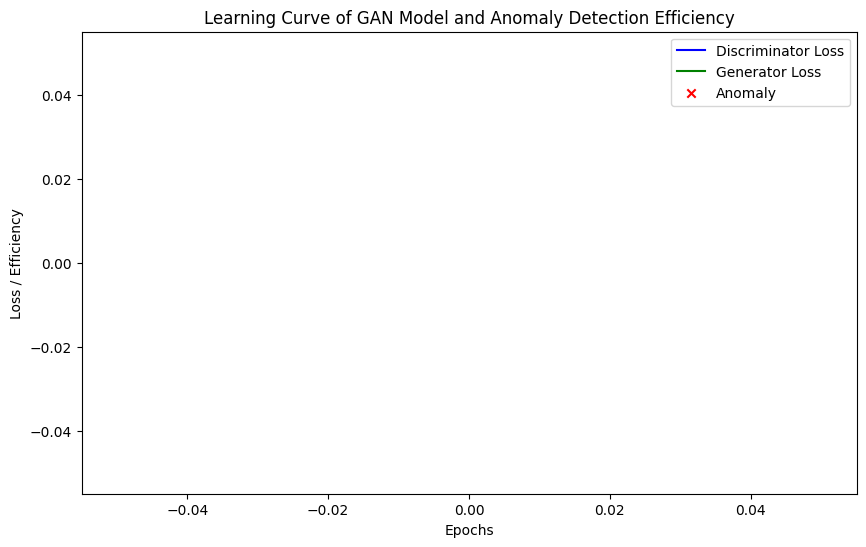

In [ ]:
# Plot the learning curve of the GAN model
plt.figure(figsize=(10, 6))

# Plot discriminator loss
plt.plot(discriminator_losses, label='Discriminator Loss', color='blue')
# Plot generator loss
plt.plot(generator_losses, label='Generator Loss', color='green')

# Identify anomalous samples
anomaly_indices = np.where(anomaly_scores > threshold)[0]
anomaly_times = list(range(X.shape[0], X.shape[0] + num_fake_samples))
anomaly_values = fake_samples[anomaly_indices]

# Plot anomaly detection efficiency
plt.scatter(anomaly_times[:len(anomaly_values)], anomaly_values[:, 0], color='red', marker='x', label='Anomaly')

plt.title('Learning Curve of GAN Model and Anomaly Detection Efficiency')
plt.xlabel('Epochs')
plt.ylabel('Loss / Efficiency')
plt.legend()
plt.show()
